In [1]:
import torch
from torch import nn
import kornia
import best.singular_point as sp
from teste_util import *

# Fixar a semente do Torch para operações específicas
fixed_seed()

# leitura dos dados
trainloader,testloader =read_dataload_flower(sp.args.img_size,'./data/datasets',batch_size=60)
# trainloader,testloader =read_dataload_fibers(sp.args.img_size)
# trainloader,testloader=read_dataload_woods(sp.args.img_size)
iterator=iter(testloader)
img,labels = next(iterator)
print(img.shape)

# Carregar o modelo singular points
path_siamese = './data/models/sp_map_fo_30.pth'
# path_siamese = './data/models/sp2_75.pth'

sp.args.num_channels = 1
model = sp.SingularPoints(args=sp.args).to(sp.device)
load_model(model,path_siamese,sp.device)

#gerar variacao de transformacoes pespectivas e fotometrica
params_lists =AugmentationParamsGenerator(6,img.shape)


torch.Size([60, 1, 120, 120])
Namespace(exported=False, num_channels=1, pyramid_levels=3, scale_pyramid=1.3, dim_first=3, dim_second=5, dim_third=8, group_size=36, epochs=70, border_size=12, box_size=21, nms_size=5, img_size=120, batch_size=16, path_data='./data', path_model='model.pt', is_loss_ssim=True, margin_loss=2.0, outlier_rejection=False, show_feature=False)


/home/wagner/.local/lib/python3.11/site-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  full_mask[mask] = norms.to(torch.uint8)


Model loaded from ./data/models/sp_map_fo_30.pth


In [2]:

from kornia.feature.scale_space_detector import get_default_detector_config, MultiResolutionDetector
from kornia.feature.keynet import KeyNetDetector

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


keynet_default_config = {
    'num_filters': 8,
    'num_levels': 3,
    'kernel_size': 5,
    # 'Detector_conf': {'nms_size': 15, 'pyramid_levels': 1, 'up_levels': 1, 'scale_factor_levels': 1.3, 's_mult': 22.0},
    'Detector_conf': {'nms_size': 5, 'pyramid_levels': 0, 'up_levels': 0, 'scale_factor_levels': 1.0, 's_mult': 5.0},
   #  'Detector_conf': {'nms_size': 5, 'pyramid_levels': 3, 'up_levels': 2, 'scale_factor_levels': 1.3, 's_mult': 12.0},# flowers 420/1020  0.411
   #  'Detector_conf': {'nms_size': 7, 'pyramid_levels': 2, 'up_levels': 1, 'scale_factor_levels': 1.3, 's_mult': 14.0}#fibers
   #  'Detector_conf': {'nms_size': 7, 'pyramid_levels': 2, 'up_levels': 1, 'scale_factor_levels': 1.3, 's_mult': 14.0}#woods 253/496 - 0.510
#    'Detector_conf': {'nms_size': 9, 'pyramid_levels': 2, 'up_levels': 1, 'scale_factor_levels': 1.5, 's_mult': 14.0},#woods  hard 262/496 - 0.528
   # 'Detector_conf': {'nms_size': 7, 'pyramid_levels': 2, 'up_levels': 1, 'scale_factor_levels': 1.3, 's_mult': 14.0},#woods  sift 245/496 - 0.494
}
descritor = kornia.feature.SIFTDescriptor(13, rootsift=True)
detector1 = KeyNetDetector(num_features=60, keynet_conf=keynet_default_config,ori_module=kornia.feature.LAFOrienter(32)).to(device)

In [3]:
# from external.hardnet_pytorch import HardNet        
# class Descriptor(nn.Module):
#         def __init__(self) -> None:
#            super().__init__()           
#            hardnet = HardNet()
#            checkpoint = torch.load('trained_models/pretrained_nets/HardNet++.pth')
#            hardnet.load_state_dict(checkpoint['state_dict'])
#            hardnet.eval()
#            hardnet.to(sp.device) 
#            self.model = hardnet
#         def forward(self, x):
#            return self.model(x)
# descritor = Descriptor()

In [4]:
class Detector(nn.Module):
        def __init__(self,model) -> None:
           super().__init__()
           self.model = model
        def forward(self, x):
            features_key,features_key_summary,features_ori,features_ori_summary,max_coords_values, max_map= self.model(x)
            return features_key_summary
detec = Detector(model)
detector1 = CustomNetDetector(detec,PS=32,keynet_conf=keynet_default_config,num_features=60).to(sp.device)

In [5]:
# import argparse

# ## for fix seed
# import random, torch, numpy 
# def get_config(jupyter=False):
#     parser = argparse.ArgumentParser(description='Train REKD Architecture')

#     ## basic configuration
#     parser.add_argument('--data_dir', type=str, default='../ImageNet2012/ILSVRC2012_img_val', #default='path-to-ImageNet',
#                             help='The root path to the data from which the synthetic dataset will be created.')
#     parser.add_argument('--synth_dir', type=str, default='', 
#                             help='The path to save the generated sythetic image pairs.')
#     parser.add_argument('--log_dir', type=str, default='trained_models/weights',
#                             help='The path to save the REKD weights.')
#     parser.add_argument('--load_dir', type=str, default='',
#                         help='Set saved model parameters if resume training is desired.')                            
#     parser.add_argument('--exp_name', type=str, default='REKD',
#                             help='The Rotaton-equivaraiant Keypoint Detection (REKD) experiment name')
#     ## network architecture
#     parser.add_argument('--factor_scaling_pyramid', type=float, default=1.2,
#                         help='The scale factor between the multi-scale pyramid levels in the architecture.')
#     parser.add_argument('--group_size', type=int, default=36,  
#                         help='The number of groups for the group convolution.')
#     parser.add_argument('--dim_first', type=int, default=2,
#                         help='The number of channels of the first layer')
#     parser.add_argument('--dim_second', type=int, default=2,
#                         help='The number of channels of the second layer')
#     parser.add_argument('--dim_third', type=int, default=2,
#                         help='The number of channels of the thrid layer')                       
#     ## network training
#     parser.add_argument('--batch_size', type=int, default=16,
#                         help='The batch size for training.')
#     parser.add_argument('--num_epochs', type=int, default=20, 
#                         help='Number of epochs for training.')
#     ## Loss function  
#     parser.add_argument('--init_initial_learning_rate', type=float, default=1e-3,
#                         help='The init initial learning rate value.')
#     parser.add_argument('--MSIP_sizes', type=str, default="8,16,24,32,40",
#                         help='MSIP sizes.')
#     parser.add_argument('--MSIP_factor_loss', type=str, default="256.0,64.0,16.0,4.0,1.0",
#                         help='MSIP loss balancing parameters.')
#     parser.add_argument('--ori_loss_balance', type=float, default=100., 
#                         help='')
#     ## Dataset generation
#     parser.add_argument('--patch_size', type=int, default=192,
#                         help='The patch size of the generated dataset.')
#     parser.add_argument('--max_angle', type=int, default=180,
#                         help='The max angle value for generating a synthetic view to train REKD.')
#     parser.add_argument('--min_scale', type=float, default=1.0,
#                         help='The min scale value for generating a synthetic view to train REKD.')
#     parser.add_argument('--max_scale', type=float, default=1.0,
#                         help='The max scale value for generating a synthetic view to train REKD.')
#     parser.add_argument('--max_shearing', type=float, default=0.0,
#                         help='The max shearing value for generating a synthetic view to train REKD.')
#     parser.add_argument('--num_training_data', type=int, default=9000,
#                         help='The number of the generated dataset.')
#     parser.add_argument('--is_debugging', type=bool, default=False,
#                         help='Set variable to True if you desire to train network on a smaller dataset.')
#     ## For eval/inference
#     parser.add_argument('--num_points', type=int, default=1500,
#                         help='the number of points at evaluation time.')
#     parser.add_argument('--pyramid_levels', type=int, default=5,
#                         help='downsampling pyramid levels.')
#     parser.add_argument('--upsampled_levels', type=int, default=2,
#                         help='upsampling image levels.')
#     parser.add_argument('--nms_size', type=int, default=15,
#                         help='The NMS size for computing the validation repeatability.')
#     parser.add_argument('--border_size', type=int, default=15,
#                         help='The number of pixels to remove from the borders to compute the repeatability.')
#     ## For HPatches evaluation
#     parser.add_argument('--hpatches_path', type=str, default='./datasets/hpatches-sequences-release',
#                         help='dataset ')
#     parser.add_argument('--eval_split', type=str, default='debug',
#                         help='debug, view, illum, full, debug_view, debug_illum ...')      
#     parser.add_argument('--descriptor', type=str, default="hardnet",
#                         help='hardnet, sosnet, hynet')    

#     args = parser.parse_args() if not jupyter else parser.parse_args(args=[])   

#     fixed_seed()

#     if args.synth_dir == "":
#         args.synth_dir = 'datasets/synth_data'

#     args.MSIP_sizes = [int(i) for i in args.MSIP_sizes.split(",")]
#     args.MSIP_factor_loss =[float(i) for i in args.MSIP_factor_loss.split(",")]

#     return args


# from external.REKD import REKD, count_model_parameters
# from external.hardnet_pytorch import HardNet

# args = get_config(jupyter=True)
# args.load_dir =  'trained_models/release_group36_f2_s2_t2.log/best_model.pt'

# from torch import nn
# class Detector(nn.Module):
#         def __init__(self) -> None:
#            super().__init__()
#            detec = REKD(args, device)
#            detec = detec.to(device) ## use GPU
#            detec.load_state_dict(torch.load(args.load_dir))  ## Load the PyTorch learnable model parameters.
#            detec.eval()
#            self.model = detec
           
#         def forward(self, x):
#             features_key,features_ori= self.model(x)
#             return features_key


# detec = Detector()
# detector1 = CustomNetDetector(detec,PS=32,keynet_conf=keynet_default_config,num_features=60).to(sp.device)

In [6]:
from kornia.feature import laf_from_center_scale_ori
def convert_points_to_lafs(points,img1, PS=19,scale=6):
    orient = kornia.feature.LAFOrienter(PS)#kornia.feature.LAFOrienter(PS)PassLAF()
    scale_lafs = torch.ones(img1.shape[0],points.shape[1],1,1)*scale
    scale_lafs = scale_lafs.to(img1.device)
    points = points.to(img1.device)
    lafs1 = laf_from_center_scale_ori(points,scale_lafs)
    lafs2 = orient(lafs1, img1)
    return lafs2
    
def extract_patches_simple(batch, lafs, PS=19):
    imgs_patches = kornia.feature.extract_patches_from_pyramid(batch, lafs, PS)
    imgs_patches =imgs_patches.reshape(-1,imgs_patches.shape[2],PS,PS)
    return imgs_patches

def plot_patches_side_by_side(imgs_patches):
    num_imgs = imgs_patches.shape[0]  # Número de imagens
    fig, axs = plt.subplots(1, num_imgs, figsize=(num_imgs*4, 4))

    axs = axs.reshape((1, num_imgs))  # Ajustar a forma para matriz 2D com uma única linha

    for i in range(num_imgs):
        axs[0, i].imshow(kornia.tensor_to_image(imgs_patches[i]))
        axs[0, i].axis('off')

    plt.show()

In [14]:
import numpy as np
from scipy.spatial.distance import cdist
import kornia.feature as KF
import matplotlib.pyplot as plt
import kornia as K

def visualize_LAF(img, LAF, img_idx = 0):
    x, y = KF.laf.get_laf_pts_to_draw(LAF, img_idx)
    print(x[0][:5],y[0][:5])
    plt.figure()
    plt.imshow(K.utils.tensor_to_image(img[img_idx]))
    plt.plot(x, y, 'r')
    plt.show()
    return

def plot_matches_keypoints(image1, keypoints1, image2, keypoints2, matches, **kwargs):
    print('image1 shape: ',image1.shape,image1.dtype,image2.shape,image2.dtype)
    # Concatenar as duas imagens lado a lado
    combined_image = np.concatenate((image1, image2), axis=1)

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.imshow(combined_image)
    ax.axis('off')

    # Desenhar pontos correspondentes e linhas conectando-os
    offset = image1.shape[1]

    for i, (x, y) in enumerate(keypoints1):
        ax.plot(x, y, 'o',markerfacecolor='none', markeredgecolor='r',
                markersize=20, markeredgewidth=1)
        ax.annotate(str(i), (x, y), color='r',xytext=(10, 10), textcoords='offset points', fontsize=12)

    for i, (x, y) in enumerate(keypoints2):
        ax.plot(x+offset, y, 'o',markerfacecolor='none', markeredgecolor='r',
                markersize=20, markeredgewidth=1)
        ax.annotate(str(i), (x+offset, y), color='r',xytext=(10, 10), textcoords='offset points', fontsize=12)

    for match in matches:
        x1, y1 = keypoints1[match[0],0], keypoints1[match[0],1]
        x2, y2 = keypoints2[match[1],0]+offset, keypoints2[match[1],1]
        ax.plot([x1, x2], [y1, y2], '-', color='lime', lw=0.5)

    plt.tight_layout()
    plt.show()

def plot_image_with_keypoints(image_tensor, keypoints_tensor):
    # Converter a imagem tensorial em objeto PIL.Image
    image = kornia.utils.tensor_to_image(image_tensor)
    # Plotar a imagem e os keypoints
    plt.imshow(image)
    if keypoints_tensor is not None:
        # Extrair as coordenadas x e y dos keypoints
        keypoints_x = keypoints_tensor[:,0].flatten().tolist()
        keypoints_y = keypoints_tensor[:,1].flatten().tolist()
        plt.scatter(keypoints_x, keypoints_y, c='red')
    plt.show()
    
def filtrar_keypoints(lista_de_pontos, tensor_mascara):
    # Verificar se as coordenadas estão dentro das dimensões
    dimensao_max_x, dimensao_max_y = tensor_mascara.shape[1] - 1, tensor_mascara.shape[0] - 1
    pontos_filtrados = [
        ponto.tolist()  for ponto in lista_de_pontos 
        if 0 <= ponto[0] <= dimensao_max_x 
        and 0 <= ponto[1] <= dimensao_max_y 
        and tensor_mascara[int(ponto[1]), int(ponto[0])] 
    ]
    return torch.tensor(pontos_filtrados)

def filtrar_keypoints_conjuntos(lista_de_pontos_1, lista_de_pontos_2, tensor_mascara):
    dimensao_max_x, dimensao_max_y = tensor_mascara.shape[1] - 1, tensor_mascara.shape[0] - 1
    pontos_filtrados_1 = []
    pontos_filtrados_2 = []
    
    for ponto_1, ponto_2 in zip(lista_de_pontos_1.cpu(), lista_de_pontos_2.cpu()):
        x, y = ponto_1
        if 0 <= x <= dimensao_max_x and 0 <= y <= dimensao_max_y and tensor_mascara[int(y), int(x)]:
            pontos_filtrados_1.append(ponto_1.numpy())
            pontos_filtrados_2.append(ponto_2.numpy())
            
    return torch.tensor(pontos_filtrados_1), torch.tensor(pontos_filtrados_2)

def find_best_matching_indices_knn(points1, points2, threshold, k=3):
    if len(points1) == 0 or len(points2) == 0:
        return []
    distances = cdist(points1, points2)
    best_indices = np.argsort(distances, axis=1)[:, :k]
    best_distances = np.take_along_axis(distances, best_indices, axis=1)

    matched = []

    for i in range(len(points1)):
        min_distance = np.min(best_distances[i])
        if min_distance < threshold:
            best_index = np.argmin(best_distances[i])
            matched.append((i, best_indices[i, best_index]))

    return matched

def calcular_associacao(matches1, matches2):
    intersecao = set(tuple(match) for match in matches1) & set(tuple(match) for match in matches2)
    # assoc_score = len(intersecao) / min(matches1.shape[0], matches2.shape[0])
    return intersecao #assoc_score


def detect_extract_feat_in_batch(batch1,aug_list, detector):
    total = []
    intersecao_total = []
    with torch.no_grad():
        for img1  in batch1:            
            lafs1, resps1 = detector(img1[None])
            B,C,H,W = img1[None].shape
            mask = torch.ones(B,C,H,W).to(img1.device) 
            #lafs1 to points1
            points1 =kornia.feature.get_laf_center(lafs1)   

            if( points1.shape[1] == 0):
                # print('aug_list shape: ',points1.shape) 
                continue                    
            img2,mask_t,ponts_t=aug_list(img1,mask,points1)     
                               
            lafs2, resps2 = detector(img2)            
            points2 =kornia.feature.get_laf_center(lafs2)
            visualize_LAF(img2, lafs2, 0)
                        
            # pontos filtrados com base da mascara
            filtered_points1,filtered_points0 = filtrar_keypoints_conjuntos(ponts_t[0],points1[0],mask_t[0,0].bool())
            filtered_points2 = filtrar_keypoints(points2[0],mask_t[0,0].bool())                        
            print('filtered shape: ',filtered_points1.shape,filtered_points2.shape)
            if( filtered_points1.shape[0] == 0 or filtered_points2.shape[0] == 0):
                # print('filtered shape: ',filtered_points1.shape,filtered_points2.shape)
                continue                        
            
            #0.5 1.0 1.5 3.5
            matches = find_best_matching_indices_knn(filtered_points1.cpu(), filtered_points2.cpu(), threshold=0.5, k=1)
            if(len(matches) == 0):
                # print('matches shape: ',len(matches))
                continue
            
            # print('filtered_points1 shape: ',filtered_points0.shape,filtered_points1.shape,filtered_points2.shape)
            lafs1 = convert_points_to_lafs(filtered_points0[None],img1[None], PS=19,scale=5)
            lafs2 = convert_points_to_lafs(filtered_points2[None],img2, PS=19,scale=5)
            # print('lafs1 shape: ',lafs1.shape,lafs2.shape,img1.shape,img2.shape)
            patch1 = extract_patches_simple(img1[None], lafs1, PS=13)
            patch2 = extract_patches_simple(img2, lafs2, PS=13)
 
            B, N, CH, H, W = patch1[None].size()        
            desc1 =descritor(patch1.view(B * N, CH, H, W))
            B, N, CH, H, W = patch2[None].size()
            desc2 =descritor(patch2.view(B * N, CH, H, W))                        
            #TODO: verificar a correspondencia entre os descritores

            dist,match_desc = kornia.feature.match_smnn(desc1, desc2, th=0.8) 
            
            # print('calcular_associacao ',match_desc.shape,len(matches))            
            intersecao = calcular_associacao(match_desc.cpu().numpy(), np.array(matches)) 
            total.append(len(matches))
            intersecao_total.append(len(intersecao))            
            # plot_matches_keypoints(img2[0,0].cpu().numpy(), filtered_points1.cpu().numpy(), img2[0,0].cpu().numpy(), filtered_points2.cpu().numpy(), matches)
            # plot_matches_keypoints(img2[0,0].cpu().numpy(), filtered_points1.cpu().numpy(), img2[0,0].cpu().numpy(), filtered_points2.cpu().numpy(), match_desc)
    print('total: ',np.sum(total),' intersecao: ',np.sum(intersecao_total))
    return (np.sum(intersecao_total)/np.sum(total))*100



  0%|          | 0/17 [00:00<?, ?it/s]

[85.0, 44.0, 66.0, 73.0, 76.0] [51.0, 30.0, 16.0, 26.0, 73.0]


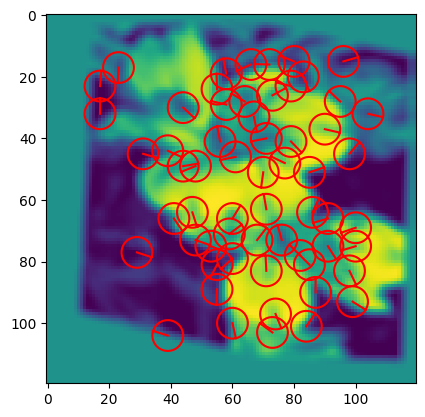

[71.0, 42.0, 54.0, 85.0, 56.0] [42.0, 39.0, 43.0, 76.0, 32.0]


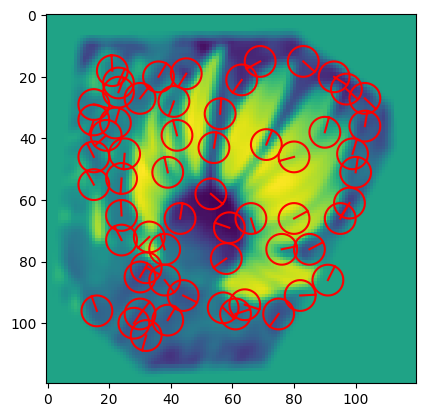

[40.0, 56.0, 39.0, 85.0, 15.0] [38.0, 22.0, 27.0, 45.0, 99.0]


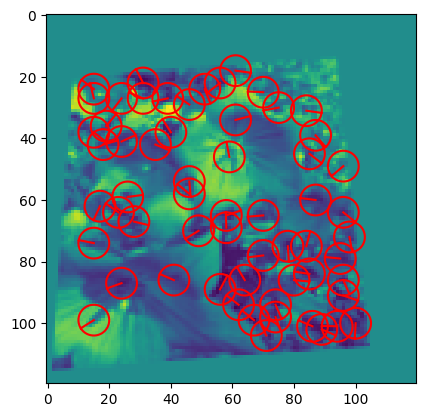

[34.0, 37.0, 46.0, 56.0, 74.0] [48.0, 46.0, 66.0, 74.0, 69.0]


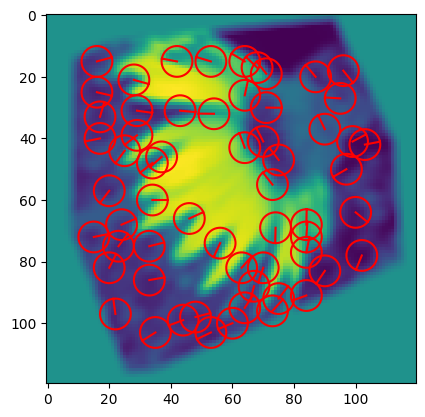

[88.0, 102.0, 32.0, 95.0, 96.0] [41.0, 37.0, 104.0, 31.0, 73.0]


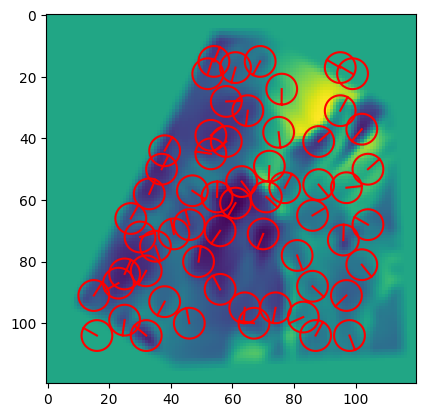

[22.0, 15.0, 88.0, 20.0, 39.0] [97.0, 50.0, 85.0, 45.0, 17.0]


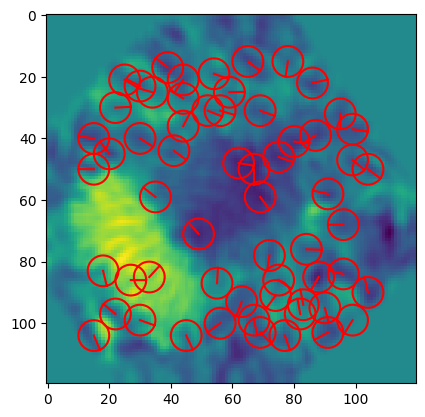

[29.0, 49.0, 23.0, 52.0, 26.0] [56.0, 67.0, 69.0, 68.0, 85.0]


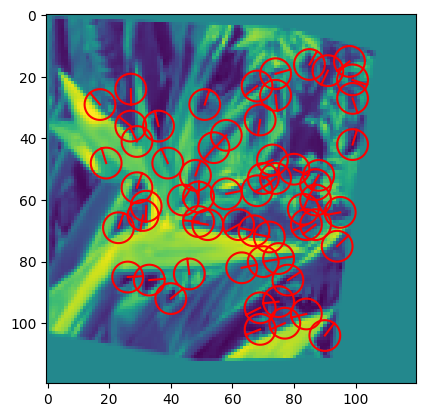

[73.0, 84.0, 88.0, 95.0, 33.0] [58.0, 33.0, 45.0, 64.0, 73.0]


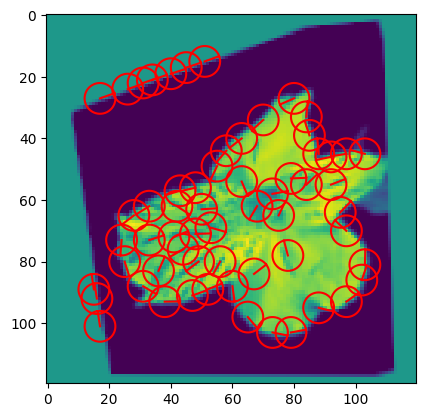

[39.0, 86.0, 35.0, 22.0, 88.0] [41.0, 19.0, 37.0, 15.0, 32.0]


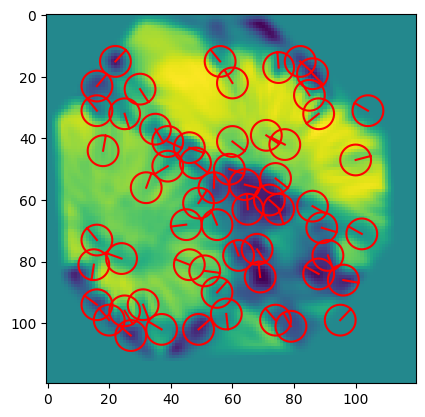

[28.0, 39.0, 55.0, 48.0, 36.0] [57.0, 56.0, 42.0, 68.0, 50.0]


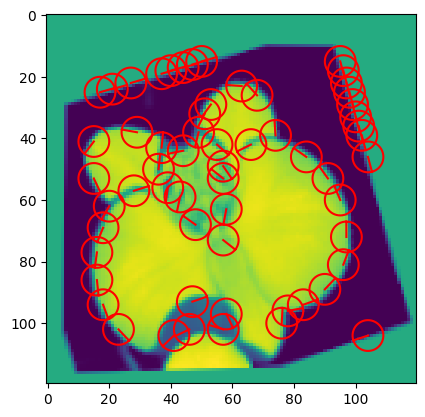

[96.0, 16.0, 17.0, 19.0, 23.0] [20.0, 90.0, 67.0, 23.0, 34.0]


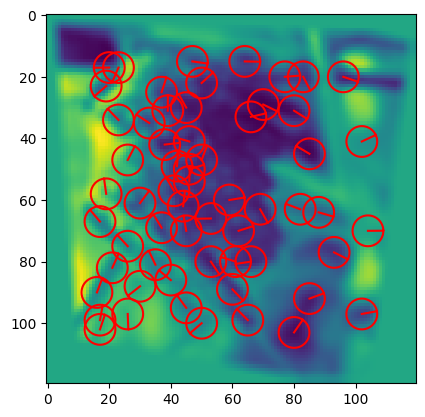

[49.0, 66.0, 25.0, 63.0, 74.0] [22.0, 45.0, 65.0, 33.0, 41.0]


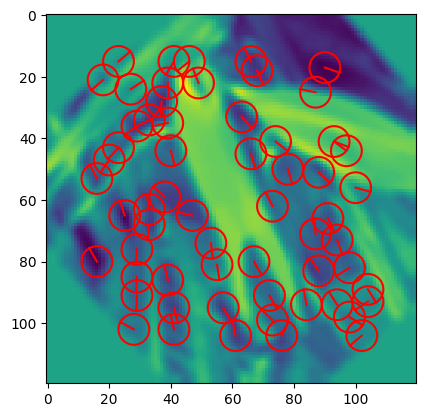

[46.0, 39.0, 33.0, 35.0, 48.0] [65.0, 66.0, 66.0, 57.0, 49.0]


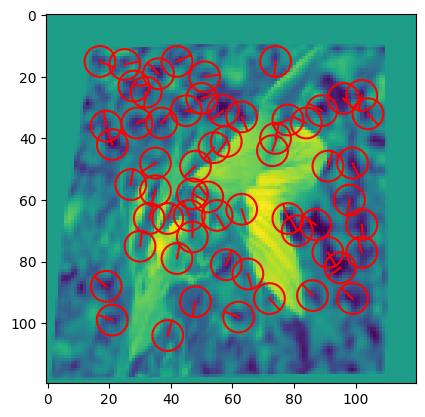

[92.0, 83.0, 63.0, 80.0, 66.0] [55.0, 53.0, 34.0, 47.0, 37.0]


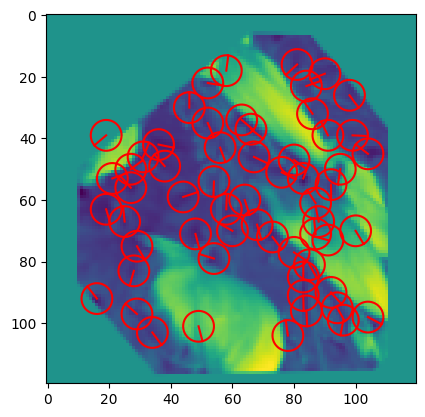

[97.0, 91.0, 102.0, 85.0, 48.0] [77.0, 80.0, 75.0, 83.0, 93.0]


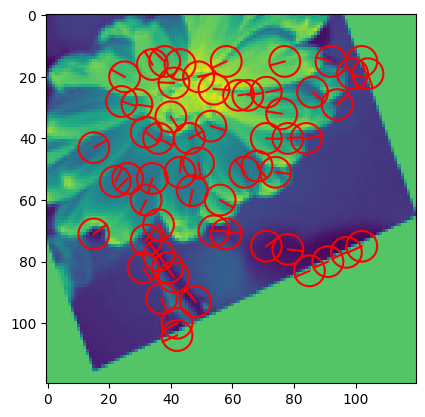

[32.0, 100.0, 16.0, 41.0, 73.0] [104.0, 42.0, 80.0, 104.0, 50.0]


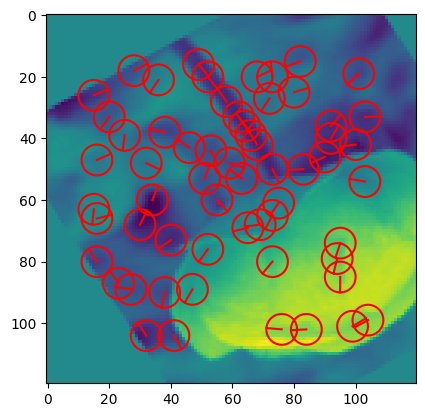

[18.0, 15.0, 95.0, 88.0, 93.0] [98.0, 44.0, 66.0, 80.0, 74.0]


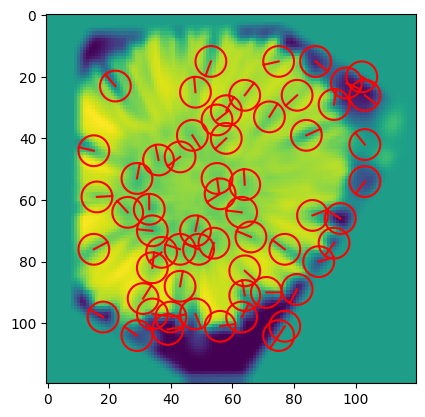

[84.0, 99.0, 28.0, 80.0, 100.0] [55.0, 92.0, 63.0, 42.0, 84.0]


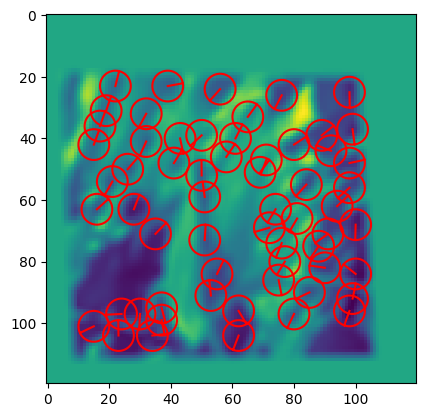

[90.0, 103.0, 47.0, 77.0, 78.0] [78.0, 48.0, 30.0, 67.0, 58.0]


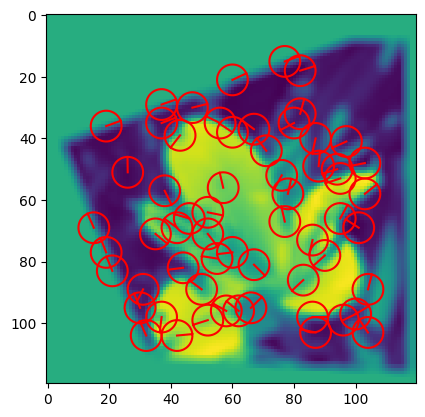

[86.0, 77.0, 103.0, 53.0, 93.0] [78.0, 86.0, 61.0, 45.0, 100.0]


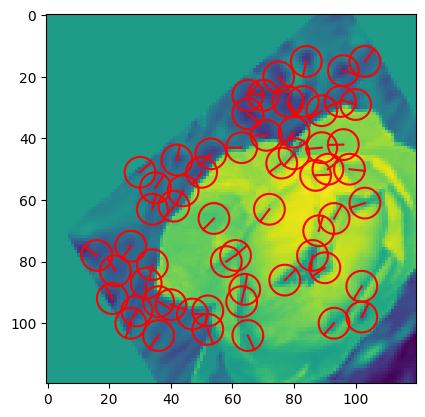

[66.0, 53.0, 98.0, 47.0, 98.0] [31.0, 30.0, 86.0, 30.0, 95.0]


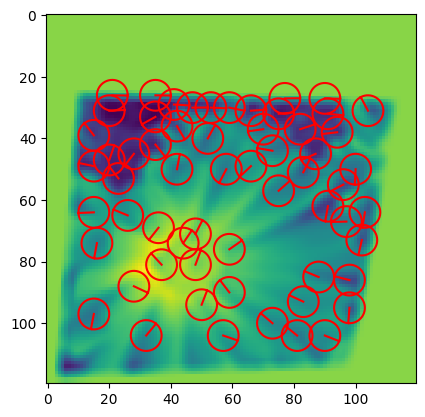

[39.0, 91.0, 104.0, 95.0, 54.0] [35.0, 38.0, 61.0, 100.0, 21.0]


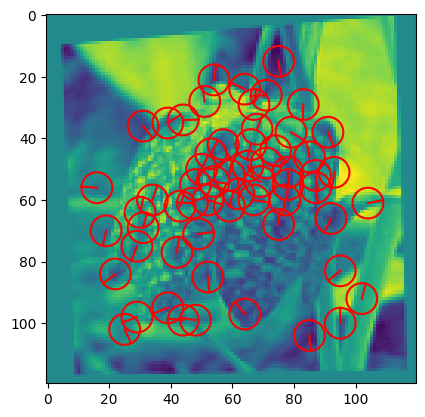

[19.0, 29.0, 33.0, 103.0, 64.0] [83.0, 76.0, 85.0, 15.0, 71.0]


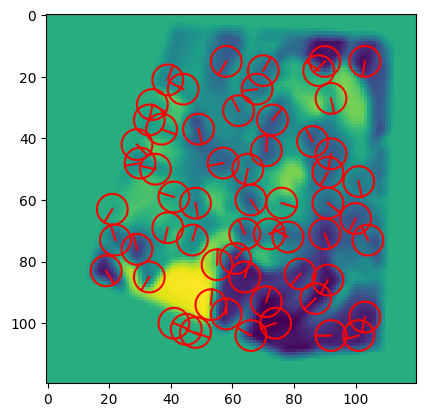

[32.0, 21.0, 56.0, 52.0, 51.0] [43.0, 52.0, 61.0, 64.0, 75.0]


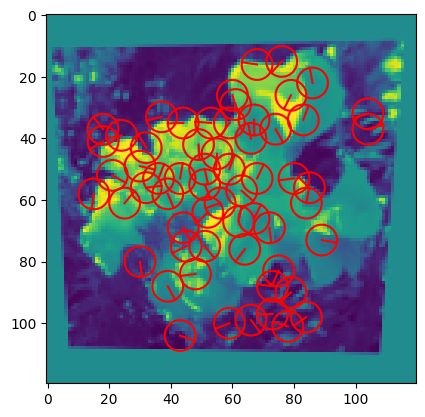

[29.0, 34.0, 48.0, 44.0, 62.0] [91.0, 87.0, 101.0, 103.0, 83.0]


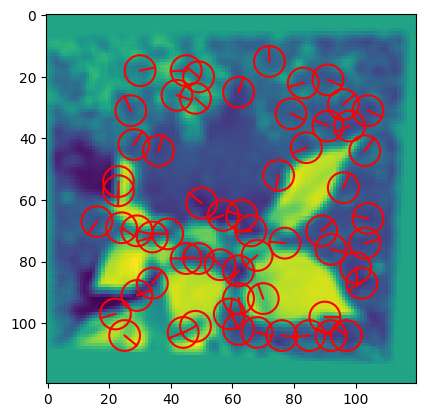

[61.0, 55.0, 56.0, 39.0, 46.0] [28.0, 54.0, 50.0, 23.0, 49.0]


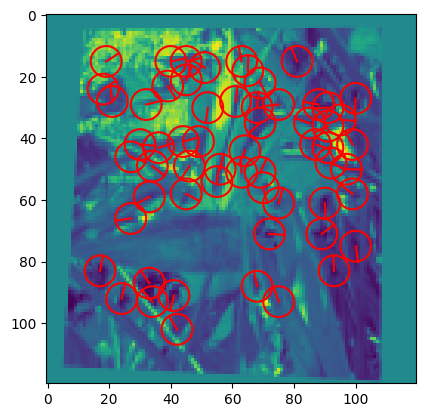

KeyboardInterrupt: 

In [15]:
fixed_seed()
params_lists.aug_list.data_keys =["input"]

transforms = kornia.augmentation.AugmentationSequential(
    kornia.augmentation.RandomAffine(degrees=360, translate=(0.2, 0.2), scale=(0.95, 1.05), shear=10,p=0.8),
    kornia.augmentation.RandomPerspective(0.2, p=0.7),
    kornia.augmentation.RandomBoxBlur((4,4),p=0.5),
    # kornia.augmentation.RandomEqualize(p=0.3),
    data_keys=["input", "mask","keypoints"],
    same_on_batch=True,
    # random_apply=10,
)

acertos = 0
total = 0
from tqdm.notebook import tqdm
pbar =  tqdm(testloader)
list_acc = []
for imgs_batch,labels_batch in pbar:# itera em todo dataset
    imgs_batch = imgs_batch.to(device)
    _acc = detect_extract_feat_in_batch(imgs_batch,transforms,detector1)
    print(_acc)
    list_acc.append(_acc)
print('match of dataset ',np.mean(list_acc))
